# Solve the forward pass when u flutuates quite fast, using an LBFGS framework



# Libraries

In [1]:
from scipy import integrate as inte
import numpy as np
import matplotlib.pyplot as plt
import do_mpc
from casadi import *
from matplotlib.animation import FuncAnimation

%matplotlib notebook

In [2]:
def plot_car_trajectory(simulator,sampling_freq):
    fig,ax = plt.subplots(2,3, figsize=(12, 9))
    
    states_sim = simulator.data['_x'][::sampling_freq]
    time =  simulator.data['_time'][::sampling_freq]
    friction = simulator.data['_tvp'][::sampling_freq,0]
    wind = simulator.data['_tvp'][::sampling_freq,1]
    force = simulator.data['_u'][::sampling_freq]
    
    ax[0,0].plot(time,states_sim[:,1]*3.6)
    ax[0,0].set_xlabel("Time")
    ax[0,0].set_ylabel("Velocity (km/hr)")    
    
    dist = states_sim[:,0]/1000
    ax[0,1].plot(time,dist)
    ax[0,1].set_xlabel("Time")
    ax[0,1].set_ylabel("Distance (km)")     
    ax[1,0].plot(time,friction*(1-exp(-states_sim[:,1])),label = "Rolling")
    

    ax[1,0].plot(time,k1*states_sim[:,1]**2,label = "Aero")
    ax[1,0].plot(time,wind,label = "Wind")
    ax[1,0].set_xlabel("Time")
    ax[1,0].set_ylabel("Drag Components")    
    ax[1,0].legend(loc="upper right")
    
    ax[1,1].plot(time,force)
    ax[1,1].set_xlabel("Time")
    ax[1,1].set_ylabel("Acceleration input")     
    
    total_fuel_burn = np.cumsum(a_0 + a_1*force)/1000
    ax[0,2].plot(time,total_fuel_burn)
    ax[0,2].set_xlabel("Time")
    ax[0,2].set_ylabel("Total Fuel Burn (klitres)")     
    instaneous_milage = (total_fuel_burn[1:] - total_fuel_burn[0:-1]) / (dist[1:] - dist[0:-1])

    ax[1,2].plot(time[1:],instaneous_milage)
    ax[1,2].set_xlabel("Time (secs)")
    ax[1,2].set_ylabel("Instaneous Milage (klitres/km)")     

In [3]:
# Defining the constants

a_0 = 0 # assume that fuel burn and force are 1-1 correlated
a_1 = 1
m = 500 # kg # car is half a ton
k1 = 50/450

model_type = 'continuous' # either 'discrete' or 'continuous'
model = do_mpc.model.Model(model_type)

x = model.set_variable(var_type='_x', var_name='x', shape=(2,1))

k0 = model.set_variable(var_type='_tvp', var_name='friction', shape=(1, 1))
fw = model.set_variable(var_type='_tvp', var_name='wind', shape=(1, 1))
acc = model.set_variable(var_type='_u', var_name='acc', shape=(1,1))

x_next = vertcat(x[1], acc/m - (k0*(1-exp(-x[1])) + k1*x[1]**2)/m - fw/m)
model.set_rhs('x',x_next)
model.setup()

params_simulator = {
    # Note: cvode doesn't support DAE systems.
    'integration_tool': 'cvodes',
    'abstol': 1e-10,
    'reltol': 1e-10,
    't_step': 1
}

simulator = do_mpc.simulator.Simulator(model)
simulator.set_param(**params_simulator)

# Set the time varying parameter
tvp_template = simulator.get_tvp_template()
def tvp_fun(t_now):
    tvp_template['wind'] = 0*np.random.normal(0,10)
    if t_now < 200:
        tvp_template['friction'] = 50
    else:
        tvp_template['friction'] = 50    
    return tvp_template

simulator.set_tvp_fun(tvp_fun)
simulator.setup()

simulator.x0 = np.array([0,0])

In [4]:
v_s = np.sqrt(450)
best_u = 50*(1-np.exp(-v_s)) + 50/450*v_s**2

In [5]:
def expert_controller(simulator,target_vel):
    current_distance = simulator.data['_x'][-1,0]
    current_velocity = simulator.data['_x'][-1,1]
    current_force = simulator.data['_u'][-1]
    if current_velocity < target_vel and current_force == 0:
        u0 = (150 + 1)*np.ones((1,1))
    elif current_velocity < target_vel and current_force > 0:
        u0 = (current_force + 1)*np.ones((1,1))
    else:
        u0 = 0*np.ones((1,1))
    return u0

In [6]:
u0 = best_u*np.ones((1,1))
simulator.reset_history()
simulator.x0 = np.array([0,0])
for i in range(200):
    simulator.make_step(u0)
    u0 = expert_controller(simulator,v_s)

<IPython.core.display.Javascript object>


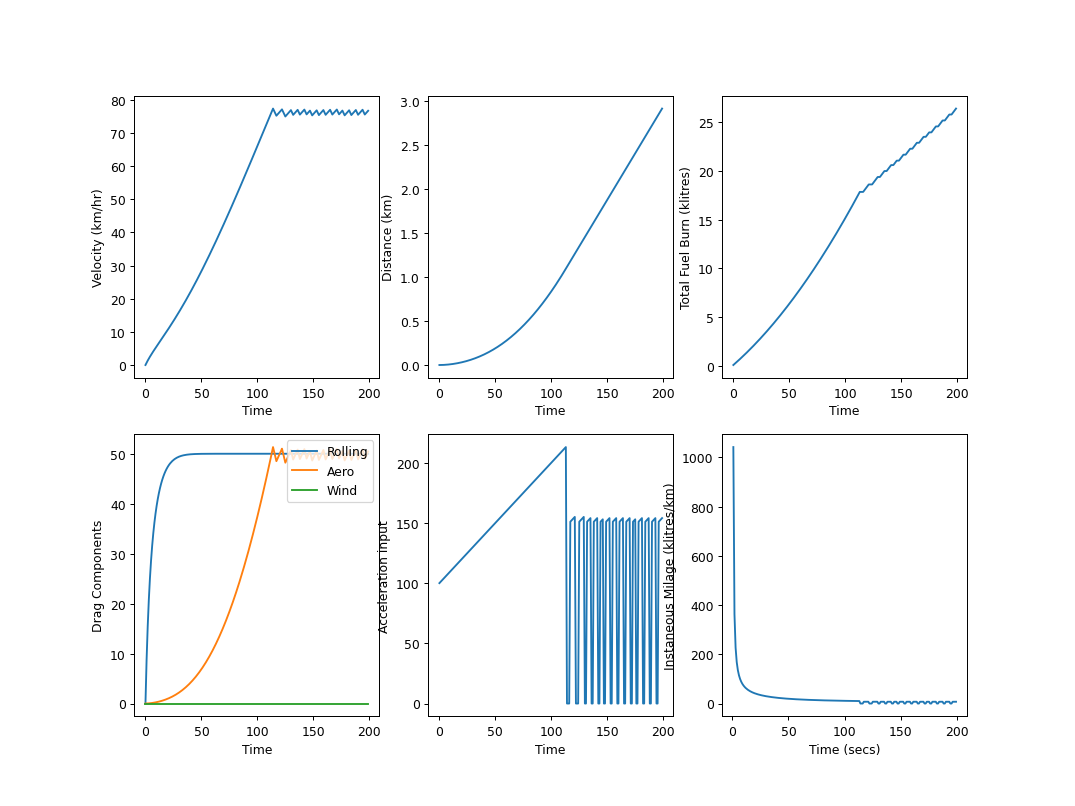

In [7]:
plot_car_trajectory(simulator,sampling_freq = 1)

In [8]:
#print the data
import pandas as pd
data = np.hstack((simulator.data['_time'], simulator.data['_x'],simulator.data['_u'],simulator.data['_tvp']))
df = pd.DataFrame(data, columns = ['time','displacement','velocity','force','friction_0','wind'])
df.to_csv('simple_car.csv')

# Now let's try to measure the friction

In [9]:
import torch
from torch import nn
import torch
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.
from torch.optim import Adam

In [10]:
class car_approx(nn.Module):
    def __init__(self,n_hidden,dim_hidden,act = nn.Tanh(),l1_init = 0.1):
        super().__init__()
        self.layer_in = nn.Linear(1,dim_hidden)
        self.layer_out = nn.Linear(dim_hidden,1)
        num_middle = n_hidden-1
        self.middle_layers = nn.ModuleList(
            [nn.Linear(dim_hidden,dim_hidden) for _ in range(num_middle)]
        )
        self.act = act
        
    def forward(self,x):
        out = self.act(self.layer_in(x))
        for layer in self.middle_layers:
            out = self.act(layer(out))
        out = self.layer_out(out)
        return out


In [11]:
class Friction_approximator(nn.Module):
    def __init__(self,n_hidden,dim_hidden,act = nn.Tanh()):
        super().__init__()
        self.layer_in = nn.Linear(1,dim_hidden)
        self.layer_out = nn.Linear(dim_hidden,1)
        num_middle = n_hidden-1
        self.middle_layers = nn.ModuleList(
            [nn.Linear(dim_hidden,dim_hidden) for _ in range(num_middle)]
        )
        self.act = act
    
    def forward(self,x):
        out = self.act(self.layer_in(x))
        for layer in self.middle_layers:
            out = self.act(layer(out))
        out = self.layer_out(out)
        return out
    
Fapprox = Friction_approximator(2,3)

In [12]:
# This is the forward function
def f(nn, x):
    return nn(x)

# This is the forward derivative function
def df(nn,x,order = 1):
    df_value = f(nn,x)
    for _ in range(order):
        df_value = torch.autograd.grad(
            df_value,
            x,
            grad_outputs = torch.ones_like(x),
            create_graph = True,
            retain_graph = True
        )[0]
    return df_value

In [13]:
# Normalising constants
Mc = 500.0
Tc = len(simulator.data['_time'])
Vc = 80.0/3.6
Uc = 250.0


def calc_de_loss(nn,rr,t_col_n,un):
    #f(rr,t_col_n)
    de_loss = Mc*Vc/Tc*1*df(nn,t_col_n,1) - (Uc*un - (50*f(rr,t_col_n)*(1-torch.exp(-Vc*f(nn,t_col_n)))+ 50/450*f(nn,t_col_n)*f(nn,t_col_n)*Vc**2 ) ) 
    return de_loss

def calc_bc_loss(nn,rr,t_data_n,vn):
    bc_loss = Vc*(f(nn,t_data_n) - vn)
    return bc_loss

def compute_loss(nn,rr,t_col_n,t_data_n,data_n):
    un = data_n[:,2].view(-1,1)
    vn = data_n[:,1].view(-1,1)
    
    de_loss = calc_de_loss(nn,rr,t_col_n,un)
    bc_loss = calc_bc_loss(nn,rr,t_data_n,vn)

    final_loss = bc_loss.pow(2).mean() + de_loss.pow(2).mean()

    return final_loss,de_loss.pow(2).mean() ,bc_loss.pow(2).mean() 


def optimise(optimiser,nn,rr,t_col_n,t_data_n,data_n):
    optimiser.zero_grad()
    loss,de_loss,bc_loss = compute_loss(nn,rr,t_col_n,t_data_n,data_n)
    loss.backward()
    optimiser.step()
    return loss,de_loss,bc_loss

In [14]:
lr = 0.01
epochs = 10000
PINN = car_approx(3,20)
F_approx = Friction_approximator(2,4)
learnable_params = list(PINN.parameters()) + list(F_approx.parameters())
pi_optimizer = Adam(learnable_params, lr=lr)

In [15]:
t_interior = torch.from_numpy(simulator.data['_time']).float()[0:400]
sensor_data = torch.from_numpy(np.hstack((simulator.data['_x'],simulator.data['_u']))).float().div(torch.tensor([[1,Vc,Uc]]))[0:400]
t_interior = t_interior.clone()/Tc

t_collocation =  t_interior.clone()
t_collocation.requires_grad = True

In [16]:
sensor_data.max(0)

torch.return_types.max(
values=tensor([2.9150e+03, 9.6725e-01, 8.5200e-01]),
indices=tensor([199, 114, 113]))

In [17]:
max(t_collocation)

tensor([0.9950], grad_fn=<UnbindBackward0>)

In [18]:
max(t_interior)

tensor([0.9950])

In [19]:
torch.tensor([[1,Vc,Uc]]).size()

torch.Size([1, 3])

<IPython.core.display.Javascript object>


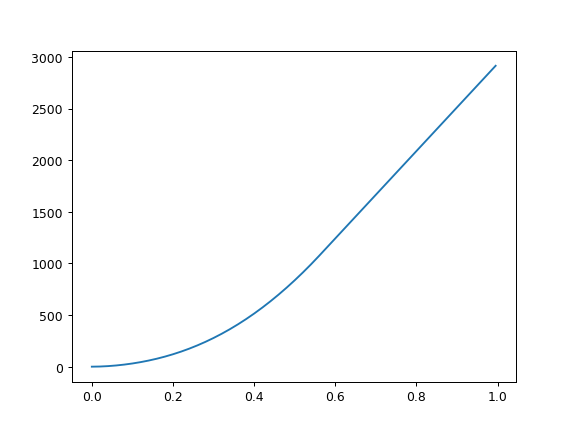

In [20]:
plt.figure()
plt.plot(t_interior,sensor_data[:,0])

In [21]:
#batch_size = 128
#loss_vector = []
#iteration_vector =[]
#for i in range(8000):
#    print(f"Epoch {i}")
#    permutation = torch.randperm(t_interior.size()[0])
#    for j in range(0,t_interior.size()[0],batch_size):
#        indices = permutation[j:j+batch_size]
#        loss,de_loss,bc_loss = optimise(pi_optimizer,PINN,F_approx,t_collocation[indices],t_interior[indices],sensor_data[indices])
#    iteration_vector.append(i)
#    loss_vector.append(loss.detach().numpy())
#    print(loss.detach().numpy(),de_loss.detach().numpy(),bc_loss.detach().numpy())

In [22]:
min_loss = 10**6

In [32]:
PATH = "model.pt"
pi_optimizer = Adam(learnable_params, lr=0.01)
full_loss_vector = []
de_loss_vector = []
bc_loss_vector = []
iteration_vector =[]
for i in range(100000):
    loss,de_loss,bc_loss = optimise(pi_optimizer,PINN,F_approx,t_collocation,t_interior,sensor_data)
    if min_loss > loss.detach().numpy().item():
        min_loss = loss.detach().numpy().item()
        best_state_pinn = PINN.state_dict() 
        best_state_friction = F_approx.state_dict()
        print(f"New Optimal found at {i}. Best loss = {min_loss}")
    if i % 1000==0:
        iteration_vector.append(i)
        full_loss_vector.append(loss.detach().numpy())
        de_loss_vector.append(de_loss.detach().numpy())
        bc_loss_vector.append(bc_loss.detach().numpy())
        print(i,loss.detach().numpy(),de_loss.detach().numpy(),bc_loss.detach().numpy())


0 111.07367 110.83574 0.23793274
1000 189.97343 189.78297 0.19046019
2000 195.39407 194.85742 0.5366466
3000 141.54318 140.6526 0.89057493
4000 132.64792 132.27057 0.37735587
New Optimal found at 4662. Best loss = 87.48204040527344
New Optimal found at 4663. Best loss = 87.29779052734375
New Optimal found at 4664. Best loss = 87.1825180053711
New Optimal found at 4665. Best loss = 87.07063293457031
New Optimal found at 4666. Best loss = 87.01414489746094
5000 119.82072 119.50481 0.31590986
New Optimal found at 5337. Best loss = 86.91475677490234
New Optimal found at 5423. Best loss = 86.3763656616211
New Optimal found at 5690. Best loss = 85.98796081542969
6000 92.169365 91.78735 0.38201264
New Optimal found at 6035. Best loss = 85.75907897949219
New Optimal found at 6370. Best loss = 85.2278823852539
New Optimal found at 6371. Best loss = 85.08029174804688
7000 113.477936 113.25962 0.21831188
New Optimal found at 7355. Best loss = 84.673583984375
New Optimal found at 7356. Best loss =

New Optimal found at 28907. Best loss = 56.39588165283203
New Optimal found at 28928. Best loss = 56.377227783203125
29000 81.783905 81.20272 0.5811834
New Optimal found at 29537. Best loss = 56.278663635253906
New Optimal found at 29538. Best loss = 55.79623031616211
New Optimal found at 29539. Best loss = 55.556941986083984
New Optimal found at 29540. Best loss = 55.44790267944336
New Optimal found at 29541. Best loss = 55.41861343383789
30000 57.765766 57.348866 0.41690108
New Optimal found at 30038. Best loss = 55.38138198852539
31000 78.725945 78.15935 0.5665943
New Optimal found at 31150. Best loss = 54.62933349609375
New Optimal found at 31171. Best loss = 54.32539749145508
New Optimal found at 31172. Best loss = 54.3137321472168
32000 67.77826 67.250885 0.5273745
New Optimal found at 32243. Best loss = 54.283287048339844
New Optimal found at 32244. Best loss = 54.167022705078125
New Optimal found at 32393. Best loss = 54.05800247192383
New Optimal found at 32394. Best loss = 53

New Optimal found at 89872. Best loss = 44.23082733154297
New Optimal found at 89873. Best loss = 44.08918380737305
90000 47.525352 47.20178 0.3235738
91000 49.835957 49.503674 0.33228168
92000 95.87579 95.46682 0.40897614
93000 67.234085 66.97497 0.2591205
New Optimal found at 93404. Best loss = 44.00518798828125
New Optimal found at 93405. Best loss = 43.70112228393555
New Optimal found at 93406. Best loss = 43.631019592285156
94000 57.524693 57.264862 0.25983152
95000 70.87297 70.62041 0.25256643
96000 91.2083 90.71659 0.4917063
New Optimal found at 96883. Best loss = 43.41273880004883
97000 66.409355 66.081985 0.32737255
New Optimal found at 97033. Best loss = 43.35348892211914
New Optimal found at 97034. Best loss = 43.25606155395508
New Optimal found at 97434. Best loss = 43.02468490600586
98000 55.055374 54.632645 0.42272958
New Optimal found at 98178. Best loss = 43.0090217590332
99000 74.11648 73.836555 0.27992204
New Optimal found at 99889. Best loss = 42.365238189697266
New 

In [38]:
PINN_optimal = car_approx(3,20)
PINN_optimal.load_state_dict(best_state_pinn)

<All keys matched successfully>

In [39]:
friction_optimal = Friction_approximator(2,4)
friction_optimal.load_state_dict(best_state_friction)

<All keys matched successfully>

<IPython.core.display.Javascript object>


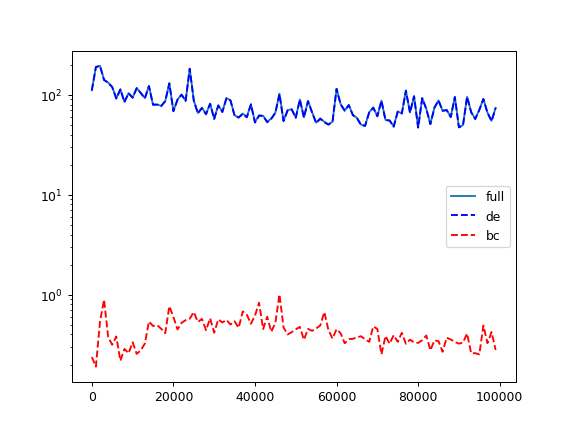

In [40]:
plt.figure()
plt.plot(iteration_vector,full_loss_vector,label = 'full')
plt.plot(iteration_vector,de_loss_vector,'b--',label = 'de')
plt.plot(iteration_vector,bc_loss_vector,'r--',label = 'bc')
plt.yscale('log')
plt.legend()

<IPython.core.display.Javascript object>


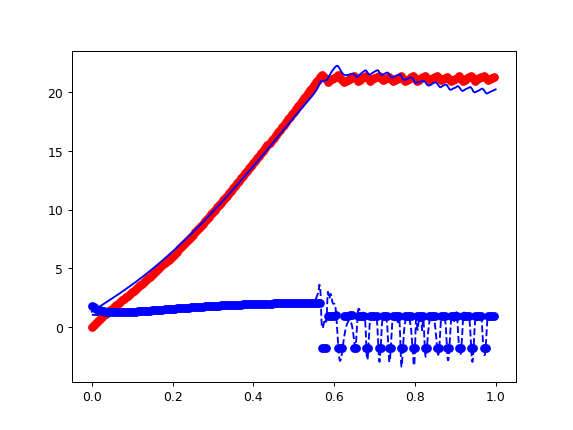

In [41]:
plt.figure()
t_data_domain = torch.linspace(0, 1, steps=1000).view(-1, 1)

with torch.no_grad():
    vel_prediction = PINN_optimal(t_data_domain).numpy()
    
t_data_domain.requires_grad = True
acc_prediction = df(PINN_optimal,t_data_domain,1).detach().numpy()

vel = sensor_data.detach().numpy()[:,1]*Vc
u = sensor_data.detach().numpy()[:,2]*Uc
acc_actual = (u/m - (50*(1-np.exp(-vel)) + 50/450*vel**2)/m)*Tc/Vc

plt.plot(t_interior.detach().numpy(),sensor_data.detach().numpy()[:,1]*Vc,'or-')
plt.plot(t_data_domain.detach().numpy(),vel_prediction*Vc,'b-')

plt.plot(t_data_domain.detach().numpy(),acc_prediction,'b--')
plt.plot(t_interior.detach().numpy(),acc_actual,'bo')

<IPython.core.display.Javascript object>


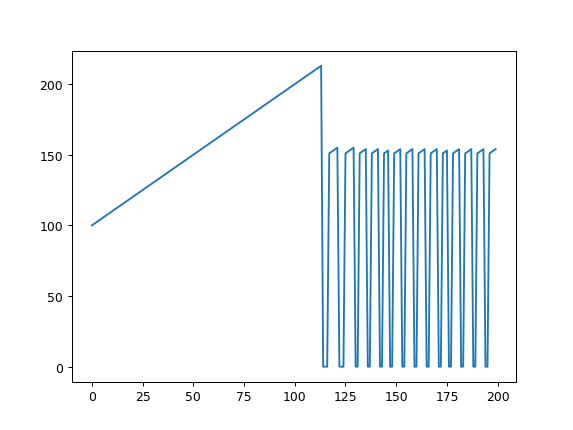

In [42]:
plt.figure()
plt.plot(u)

In [43]:
vel_data = sensor_data[:,1].view(-1,1)
u = sensor_data[:,2].view(-1,1)
de_loss = calc_de_loss(PINN_optimal,F_approx,t_collocation,u)
bc_loss = calc_bc_loss(PINN_optimal,F_approx,t_interior,vel_data)
#ic_loss = calc_ic_loss(PINN,0.0)

<IPython.core.display.Javascript object>


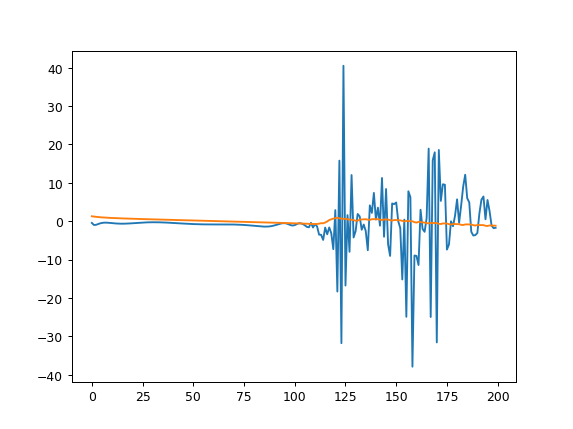

In [44]:
plt.figure()
plt.plot(de_loss.detach().numpy())
plt.plot(bc_loss.detach().numpy())

In [45]:
de_loss.pow(2).detach().numpy().mean()

54.64406

In [46]:
bc_loss.pow(2).detach().numpy().mean()

0.336195

<IPython.core.display.Javascript object>


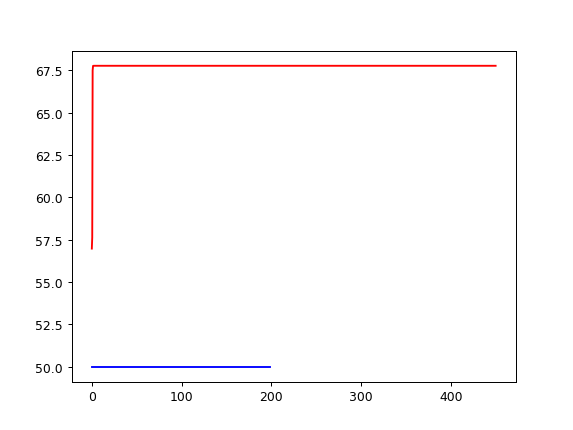

In [48]:
plt.figure()
# NOw interrogate the R approximator
t_data_domain = torch.linspace(0, 450, steps=1000).view(-1, 1)
with torch.no_grad():
    r_prediction = F_approx(t_data_domain).numpy()*50

plt.plot(t_data_domain,r_prediction,'r')
plt.plot(simulator.data['_time'],simulator.data['_tvp'][:,0],'b')